<a href="https://colab.research.google.com/github/camrobertson/FDA_Sentiment_Analysis/blob/Branch-Corpus-Development/PVP_Scrape_and_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install readability-lxml

  Created wheel for readability-lxml: filename=readability_lxml-0.7.1-cp36-none-any.whl size=16480 sha256=88de99a620597d6fdaa642740ad1323f5dadb03b4d6e10e4b37434ce273c42f7
  Stored in directory: /root/.cache/pip/wheels/94/48/e5/d944e616d8b0734c3b9cf30a21f4afcf855a1e2b85f82f34fb
Successfully built readability-lxml


In [0]:
import requests
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import urllib.parse


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:

#search_terms = [
#                "real world evidence", 
#                "RWE", 
#                "PFDD", 
#                "Patient Focused Drug Development", 
#                "Bayesian", 
#                "Bayes", 
#                "Advanced Trial Design", 
#                "Master Protocol",
#                "Adaptive Design"
#                "Oncology", 
#                "Rare",
#                "Orphan",
#                "Breakthrough",
#                "Digital"
#]

search_terms = ["RWE"]

headers = {
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.100 Safari/537.36'
}

login_data = {
    'user[email]': 'andrew.robertson@sanofi.com',
    'user[password]': 'NecroticSpn43Ac',
    #'utf8': '✓',
    'commit': 'Login'
}

Create Corpus for PVP
1. Mount Google Drive
2. Run search for all documents that have keywords (e.g., "RWE") - see https://www.youtube.com/watch?v=eRSJSKG4mDA 
3. Login to PVP
3. Grab urls for all documents that have keyword; store in dictionary (key = keyword; value = list of urls)
4.  Grab urls 1 by 1; grab date for each
5. Store html files in google drive (folder = PVP, name = PVP + date of doc + hash+.html)

In [0]:
#Step 1 = mount google cloud drive -- need to reset local variables / runtime if you want to re-execute. 

from google.colab import drive
import os
drive.mount('/content/gdrive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
target_dir = 'gdrive/My Drive/FDA_Corpus/test_run'

os.chdir('///content/' + target_dir) #CHANGE BACK TO ///content/gdrive//My Drive/FDA_Corpus/PVP
os.getcwd()

'/content/gdrive/My Drive/FDA_Corpus/test_run'

# HTMLCorpusReader

In [0]:
#!/usr/bin/env python3

import bs4
import time
import nltk
import pickle
import logging
import codecs

from nltk.corpus.reader.api import CorpusReader
from nltk.corpus.reader.api import CategorizedCorpusReader

from readability.readability import Unparseable
from readability.readability import Document as Paper
from nltk import pos_tag, sent_tokenize, wordpunct_tokenize
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')

log = logging.getLogger("readability.readability")
log.setLevel('WARNING')

DOC_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.html'
PKL_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.pickle'
CAT_PATTERN = r'([a-z_\s]+)/.*'

TAGS = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'p', 'li']


class HTMLCorpusReader(CategorizedCorpusReader, CorpusReader):
    """
    A corpus reader for raw HTML documents to enable preprocessing.
    """

    def __init__(self, root, fileids=DOC_PATTERN, encoding='utf8',
                 tags=TAGS, **kwargs):
        """
        Initialize the corpus reader.  Categorization arguments
        (``cat_pattern``, ``cat_map``, and ``cat_file``) are passed to
        the ``CategorizedCorpusReader`` constructor.  The remaining
        arguments are passed to the ``CorpusReader`` constructor.
        """
        # Add the default category pattern if not passed into the class.
        if not any(key.startswith('cat_') for key in kwargs.keys()):
            kwargs['cat_pattern'] = CAT_PATTERN

        # Initialize the NLTK corpus reader objects
        CategorizedCorpusReader.__init__(self, kwargs)
        CorpusReader.__init__(self, root, fileids, encoding)

        # Save the tags that we specifically want to extract.
        self.tags = tags

    def resolve(self, fileids, categories):
        """
        Returns a list of fileids or categories depending on what is passed
        to each internal corpus reader function. Implemented similarly to
        the NLTK ``CategorizedPlaintextCorpusReader``.
        """
        if fileids is not None and categories is not None:
            raise ValueError("Specify fileids or categories, not both")

        if categories is not None:
            return self.fileids(categories)
        return fileids

    def docs(self, fileids=None, categories=None):
        """
        Returns the complete text of an HTML document, closing the document
        after we are done reading it and yielding it in a memory safe fashion.
        """
        # Resolve the fileids and the categories
        fileids = self.resolve(fileids, categories)

        # Create a generator, loading one document into memory at a time.
        for path, encoding in self.abspaths(fileids, include_encoding=True):
            with codecs.open(path, 'r', encoding=encoding) as f:
                #print(os.listdir(), os.getcwd())
                yield f.read()

    def sizes(self, fileids=None, categories=None):
        """
        Returns a list of tuples, the fileid and size on disk of the file.
        This function is used to detect oddly large files in the corpus.
        """
        # Resolve the fileids and the categories
        fileids = self.resolve(fileids, categories)

        # Create a generator, getting every path and computing filesize
        for path in self.abspaths(fileids):
            yield os.path.getsize(path)

    def html(self, fileids=None, categories=None):
        """
        Returns the HTML content of each document, cleaning it using
        the readability-lxml library.
        """
        for doc in self.docs(fileids, categories):
            try:
                yield Paper(doc).summary()
            except Unparseable as e:
                print("Could not parse HTML: {}".format(e))
                continue

    def paras(self, fileids=None, categories=None):
        """
        Uses BeautifulSoup to parse the paragraphs from the HTML.
        """
        for html in self.html(fileids, categories):
            soup = bs4.BeautifulSoup(html, 'lxml') 
            for element in soup.find_all(self.tags):
                yield element.text
            soup.decompose()

    def sents(self, fileids=None, categories=None):
        """
        Uses the built in sentence tokenizer to extract sentences from the
        paragraphs. Note that this method uses BeautifulSoup to parse HTML.
        """
        for paragraph in self.paras(fileids, categories):
            for sentence in sent_tokenize(paragraph):
                yield sentence

    def words(self, fileids=None, categories=None):
        """
        Uses the built in word tokenizer to extract tokens from sentences.
        Note that this method uses BeautifulSoup to parse HTML content.
        """
        for sentence in self.sents(fileids, categories):
            for token in wordpunct_tokenize(sentence):
                yield token

    def tokenize(self, fileids=None, categories=None):
        """
        Segments, tokenizes, and tags a document in the corpus.
        """
        for paragraph in self.paras(fileids=fileids):
            yield [
                pos_tag(wordpunct_tokenize(sent))
                for sent in sent_tokenize(paragraph)
            ]

    def describe(self, fileids=None, categories=None):
        """
        Performs a single pass of the corpus and
        returns a dictionary with a variety of metrics
        concerning the state of the corpus.
        """
        started = time.time()

        # Structures to perform counting.
        counts  = nltk.FreqDist()
        tokens  = nltk.FreqDist()

        # Perform single pass over paragraphs, tokenize and count
        for para in self.paras(fileids, categories):
            counts['paras'] += 1

            for sent in sent_tokenize(para):
                counts['sents'] += 1

                for word in wordpunct_tokenize(sent):
                    counts['words'] += 1
                    tokens[word] += 1

        # Compute the number of files and categories in the corpus
        n_fileids = len(self.resolve(fileids, categories) or self.fileids())
        n_topics  = len(self.categories(self.resolve(fileids, categories)))

        # Return data structure with information
        return {
            'files':  n_fileids,
            'topics': n_topics,
            'paras':  counts['paras'],
            'sents':  counts['sents'],
            'words':  counts['words'],
            'vocab':  len(tokens),
            'lexdiv': float(counts['words']) / float(len(tokens)),
            'ppdoc':  float(counts['paras']) / float(n_fileids),
            'sppar':  float(counts['sents']) / float(counts['paras']),
            'secs':   time.time() - started,
        }




[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# PickleCorpusReader

In [0]:
class PickledCorpusReader(HTMLCorpusReader):

    def __init__(self, root, fileids=PKL_PATTERN, **kwargs):
        """
        Initialize the corpus reader.  Categorization arguments
        (``cat_pattern``, ``cat_map``, and ``cat_file``) are passed to
        the ``CategorizedCorpusReader`` constructor.  The remaining arguments
        are passed to the ``CorpusReader`` constructor.
        """
        # Add the default category pattern if not passed into the class.
        if not any(key.startswith('cat_') for key in kwargs.keys()):
            kwargs['cat_pattern'] = CAT_PATTERN

        CategorizedCorpusReader.__init__(self, kwargs)
        CorpusReader.__init__(self, root, fileids)

    def resolve(self, fileids, categories):
        """
        Returns a list of fileids or categories depending on what is passed
        to each internal corpus reader function. This primarily bubbles up to
        the high level ``docs`` method, but is implemented here similar to
        the nltk ``CategorizedPlaintextCorpusReader``.
        """
        if fileids is not None and categories is not None:
            raise ValueError("Specify fileids or categories, not both")

        if categories is not None:
            return self.fileids(categories)
        return fileids

    def docs(self, fileids=None, categories=None):
        """
        Returns the document loaded from a pickled object for every file in
        the corpus. Similar to the BaleenCorpusReader, this uses a generator
        to acheive memory safe iteration.
        """
        # Resolve the fileids and the categories
        fileids = self.resolve(fileids, categories)

        # Create a generator, loading one document into memory at a time.
        for path, enc, fileid in self.abspaths(fileids, True, True):
            with open(path, 'rb') as f:
                yield pickle.load(f)

    def paras(self, fileids=None, categories=None):
        """
        Returns a generator of paragraphs where each paragraph is a list of
        sentences, which is in turn a list of (token, tag) tuples.
        """
        for doc in self.docs(fileids, categories):
            for paragraph in doc:
                yield paragraph

    def sents(self, fileids=None, categories=None):
        """
        Returns a generator of sentences where each sentence is a list of
        (token, tag) tuples.
        """
        for paragraph in self.paras(fileids, categories):
            for sentence in paragraph:
                yield sentence

    def tagged(self, fileids=None, categories=None):
        for sent in self.sents(fileids, categories):
            for token in sent:
                yield token

    def words(self, fileids=None, categories=None):
        """
        Returns a generator of (token, tag) tuples.
        """
        for token in self.tagged(fileids, categories):
            yield token[0]

# PVP Scraping

In [0]:
def get_response(redirect):
  #for each url on the redirect list, it may ask for a login - we're supplying that login. 
  with requests.Session() as s:
      url = 'https://www.previsionpolicy.com/login' #will need to tailor this when I start using other sources. 
      r = s.get(url, headers=headers)
      soup = BeautifulSoup(r.content, 'html5lib')
      login_data['authenticity_token'] = soup.find('input', attrs={'name': 'authenticity_token'})['value'] #works for PVP
      login_data['redirect'] = redirect
      r.encoding = 'utf-8'
      r = s.post(url, data=login_data, headers=headers)
      #rBS = BeautifulSoup(r.text, 'html5lib') #Added 04_22_2020
      return(r) #was return(r) - but that may be a class object. See https://requests.readthedocs.io/en/master/_modules/requests/models/ for documentation

In [0]:
def get_redirect_list(query):
  #run the search on the news page to get all the necessary links, create a list "urls" that will be used as the redirects; 
  #url links are stored on redirect_list
  redirect_list = []
  term_query = urllib.parse.quote_plus(query)
  for i in range(0,20):
    with requests.Session() as s:
      url = 'https://www.previsionpolicy.com/pages?utf8=%E2%9C%93&search="'+term_query+'"+NOT+%22Clips%22&commit=&page='+str(i)
      r = s.get(url, headers=headers)
      soup = BeautifulSoup(r.content, "html5lib") 
      for t in soup.find_all('a'):
        if len(t.get('href')) > 35: redirect_list.append(t.get('href'))  #to help weed out the other links, stores all links within the redirect_list
  return(redirect_list)

In [0]:
def make_dir_if_needed():
  #make the directory if needed. 
  if not os.path.exists(query):
    os.mkdir(query)
    print("Directory " , query ,  " Created ")
  else:    
    print("Directory " , query ,  " already exists")

  os.chdir(query) 

In [0]:
#Step 3 - Cell will generate a list of urls that result from the PVP search for real world evidence
os.chdir('///content/' + target_dir) #CHANGE BACK TO ///content/gdrive//My Drive/FDA_Corpus/PVP
urls = []
file_count = {}
search_terms = ["RWE"] #Delete this --- only for trouble shooting so that I'm not doing tons of terms. 


In [0]:
#SKIP IF CORPUS IS ALREADY DEVELOPED

#For each search term in 'search_terms' - 
# 1 Preps the query to be inserted in the PVP list
# 2 collects the redirect urls for up to 20 pages (guessing that there aren't more than 20 pages of articles) 
# 3 Runs a query, gets the urls for each result (which goes into teh redirect list)
# 4 Looks up each url article in the redirect list, stores the text. 
os.chdir('///content/' + target_dir) #CHANGE BACK TO ///content/gdrive//My Drive/FDA_Corpus/PVP

for query in search_terms:
  print ('\n\n', query.upper(), '\n')
  redirect_list = get_redirect_list(query) #use each of the links in list "urls", get the text content, get the hash of the text, and save to file w/ hash in folder of search term. 
  print(redirect_list)
  
  make_dir_if_needed()
  
  for u in redirect_list:
    
    page_content = get_response(u) #to modify ... need to keep the get_text call, but ... will replace with the write file. look for tag "meta content" to get date
    
  
    file_name = u[1:40]+'.html' #create file_name from first 40 characters of url
    page_content_soup = BeautifulSoup(page_content.text, "html.parser")
       
    os.chdir('///content/' + target_dir) #CHANGE BACK TO ///content/gdrive//My Drive/FDA_Corpus/PVP  ALSO - need to split this into discrete function; should include date in the filename?
    if not os.path.isfile(file_name):
      
      #with open(file_name, "w", encoding='utf-8') as file:
      #  file.write(str(page_content_soup))
        
      f= open(file_name,'w+', encoding='utf8')
      f.write(str(page_content_soup)) #may need to change 'bytes' back to 'str'
      f.close()
      
      print("Wrote "+file_name+" Size: "+str(os.stat(file_name).st_size))

      if query in file_count.keys(): 
        file_count[query] += 1
      else:
        file_count[query] = 1
  os.chdir('///content/' + target_dir) #CHANGE BACK TO ///content/gdrive//My Drive/FDA_Corpus/PVP

In [0]:
#SKIP - ONLY USED FOR METRIC TO COUNT CORPUS FILES CREATED
os.chdir('///content/' + target_dir) #CHANGE BACK TO ///content/gdrive//My Drive/FDA_Corpus/PVP

print("\n\nSUMMARY\n Key   #Files")
tot_count = 0
for q, n in file_count.items():
  print(q, n)
  tot_count += n

print("\nTOTAL FILES = ", tot_count)

# WORKS WORKS ... next step is to write each html to a file labeled w/ date and hash. 


# Active Testing

In [0]:
#Create corpus object
corpus = HTMLCorpusReader(d, fileids=file_list)

In [0]:
for para in corpus.paras(): print(para, '\n') #WORKS!!! got rid of UTF-8.  should rerun on all files w/ all keywords.  Need to get rid of listdir() command somewhere?

In [0]:
#import nltk
nltk.download('averaged_perceptron_tagger')
for token in corpus.tokenize(): print(token)


In [0]:
for para in corpus.paras(): print(para)

In [0]:
import csv

with open('RWE_Bert_training.tsv', 'wt', newline='') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    index = 0
    for para in corpus.paras(): 
      index += 1
      tsv_writer.writerow([str(index), ' ', 'a', para ])

For output ... considering developing a class object. Would have the following:
 
 - Document Date
 - Document Name (Hashtag?)
 - Paragraph number
 - FDA Tags -- Type Dictionary; keys would be the FDA list of trigger words (FDA, Temple, Woodcock, etc.), value would be the number of occurances.
 - Keyword tags -- Type Dictionary; keys would be the keywords (RWE, PFDD, etc) value would be the number of occurances.
 - Pos_score - identifies number of positive phrases used. 
 - Neg_score - identifies number of negative phrases used. *
 *alternatively, just have a pos/minus for each paragraph token. 



In [0]:
# Not sure what this does?
from os import listdir
from os.path import isfile, join
d = os.getcwd()
file_list = [f for f in listdir(d) if isfile(join(d, f))]
d = os.getcwd()

In [0]:
class Para_Analasys:
  Doc_date = ""
  Doc_Name = ""
  Para_num = ""
  FDA_Tags = {}
  Keywd_Tags = {}
  Sent_score = 0

In [0]:
r = get_text()
print (r.content)

In [0]:
#sandbox - trying to split html into paragraphs --- THIS WORKS -- should help split HTML into paragraphs to allow for word analysis. 
r = get_text()

soup = BeautifulSoup(r.content, "html5lib")
paragraphs = []
tags = soup.find_all('p')
for t in tags: paragraphs.append(t.text)

print(paragraphs)

['\nYou have not saved any research notes.\n', 'To save a note, click the bookmark icon at the top of the article. Notes you flag will appear in this box.', 'A Bipartisan Policy Center report developed by three former FDA commissioners suggests a more active role by the Centers for Medicare & Medicaid Services could be critical to advancing the adoption of real-world evidence in drug regulation and reimbursement.', 'The August report is co-signed by Robert Califf, Andrew von Eschenbach and Mark McClellan, and is intended to “explore the benefits and challenges of using real-world data and evidence to inform regulatory and value-based payment decision-making and the policy actions needed to accelerate their use.” It follows up on the significant attention RWE received in the context of the 21st Century Cures and FDA Reauthorization Act legislation in 2016-2017.', 'Broadly speaking, the message from the report about FDA’s role is to keep moving on current activities to advance RWE. But w

In [0]:
#WORKS - gets the hash of each document read in from the internet. 

import hashlib

file_hash = hashlib.md5() # Create the hash object, can use something other than `.sha256()` if you wish
file_hash.update(r.content)
print (file_hash.hexdigest()) # Get the hexadecimal digest of the hash

Need to work on 1 paragraph at a time.  For each, do the following:
- record the date and hash of the overarching document
- record paragraph number
- tokenize paragraph by sentance; remove stopwords
- identify if FDA identifier is present, and if keyword identifier is present.
- Score positive words; score negative words on sentance by sentance basis.  

In [0]:
#tokenize using string split commands ... early attempt, should be deprioritized for NLTK
r = get_text()
soup = BeautifulSoup(r.content, "html5lib")
text = soup.get_text(strip=True)


tokens = [t for t in text.split()]
clean_tokens = tokens[:] #will generate a tokens library w/out stop words in english
sr = stopwords.words('english')
for token in tokens:
    if token in sr: clean_tokens.remove(token)

freq = nltk.FreqDist(clean_tokens)
for key, val in freq.items():
    print(str(key) + ':' + str(val))

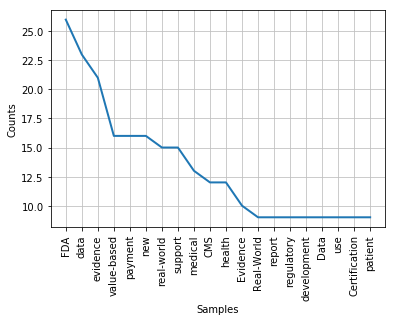

In [0]:
freq.plot(20, cumulative = False)

In [0]:
#uses NLTK to tokenize. 
from nltk import TextTilingTokenizer
tt = TextTilingTokenizer()

r = get_text()
soup = BeautifulSoup(r.content, "html5lib")
text = soup.get_text(strip=True)
s, ss, d, b = tt.tokenize(text)
